In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import torch
import torch.nn as nn
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

In [2]:
class RiskClassifier:
    def __init__(self):
        self.model = lgb.LGBMClassifier(random_state=42, is_unbalance=True)
        self.features = [
            'open', 'high', 'low', 'close', 'volume',
            'ema_50', 'ema_200', 'macd', 'macd_signal', 'macd_diff', 'rsi',
            'bollinger_hband', 'bollinger_lband', 'mfi',
            'return', 'bollinger_pct', 'bollinger_bw',
            'volatility_5d', 'volatility_10d',
            'volume_change', 'obv', 'volume_pct_20d', 'close_lag1', 'close_lag2',
            'close_lag3', 'return_lag1', 'return_lag2', 'return_lag3', 'rsi_lag1',
            'rsi_lag2', 'rsi_lag3', 'macd_lag1', 'macd_lag2', 'macd_lag3',
            'macd_diff_lag1', 'macd_diff_lag2', 'macd_diff_lag3',
            'bollinger_pct_lag1', 'bollinger_pct_lag2', 'bollinger_pct_lag3'
        ]

    def train(self, df_train_featured):
        df_train = df_train_featured.copy()
        
        test_size = 0.10
        all_Xtrain_dfs = []
        all_ytrain_dfs = []
        

        for ticker in df_train["ticker"].unique():
            df_ticker = df_train[df_train["ticker"] == ticker].copy()
            df_ticker.sort_values(by = "timestamp", inplace = True)
            split_index = int((len(df_ticker) * (1-test_size)))
            df_ticker_train = df_ticker[:split_index]
            all_Xtrain_dfs.append(df_ticker_train[self.features])
            all_ytrain_dfs.append(df_ticker_train["risk_label"])
        

        X_train = pd.concat(all_Xtrain_dfs)
        y_train = pd.concat(all_ytrain_dfs)
         
        self.model.fit(X_train, y_train)
        print("[Risk Model] Huấn luyện xong")

    def predict(self, df_today_featured):
        if df_today_featured.empty:
            return pd.Series(dtype=int)

        
        X_today = df_today_featured[self.features].dropna()
        if X_today.empty:
            return pd.Series(dtype=int)
            
        predictions = self.model.predict(X_today)
        return pd.Series(predictions, index=X_today.index)

In [3]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_classes, num_layers=2, dropout=0.3):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(hidden_layer_size * 2, num_classes)

    def forward(self, input_seq):
        device = input_seq.device
        h0 = torch.zeros(self.num_layers * 2, input_seq.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, input_seq.size(0), self.hidden_layer_size).to(device)
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

In [4]:
class SignalClassifier:
    def __init__(self, model_path, top_features, scaler_path,
                 time_steps=10, device="cpu"):
        self.model_path = model_path
        self.top_features = top_features
        self.scaler_path = scaler_path
        self.time_steps = time_steps
        self.device = device
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None

    def load_model(self, input_size, num_classes=3, hidden_size=128):
        with open(self.scaler_path, "rb") as f:
            self.scaler = pickle.load(f)

        model = LSTMClassifier(input_size=input_size, hidden_layer_size=hidden_size, num_classes=num_classes)
        model.load_state_dict(torch.load(self.model_path, map_location=self.device))
        model.to(self.device)
        model.eval()
        self.model = model
        print(f"[Signal Model] Load weight từ {self.model_path} thành công")
        print(f"[Signal Model] Load scaler từ {self.scaler_path} thành công")

    def _create_lstm_dataset(self, X_scaled):
        if len(X_scaled) < self.time_steps:
            return np.array([])
        return X_scaled[-self.time_steps:].reshape(1, self.time_steps, X_scaled.shape[1])

    def predict(self, df_history_featured):
        if df_history_featured.empty or len(df_history_featured) < self.time_steps:
            return 1 

        X_hist = df_history_featured[self.top_features].values
        X_hist_scaled = self.scaler.transform(X_hist)

        X_lstm = self._create_lstm_dataset(X_hist_scaled)
        if X_lstm.shape[0] == 0:
            return 1 
        
        X_tensor = torch.tensor(X_lstm, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            output = self.model(X_tensor)
            pred = torch.argmax(output, dim=1).item()
        
        return pred

In [5]:
def add_features(df):
    df_copy = df.copy()

    # Features cho Risk Model
    df_copy["volatility_5d"] = df_copy.groupby("ticker")["return"].rolling(5).std().reset_index(0, drop=True)
    df_copy["volatility_10d"] = df_copy.groupby("ticker")["return"].rolling(10).std().reset_index(0, drop=True)

    df_copy["volume_change"] = df_copy.groupby("ticker")["volume"].pct_change()
    
    df_copy["obv"] = (np.sign(df_copy["return"].fillna(0)) * df_copy["volume"]).groupby(df_copy["ticker"]).cumsum()
    
    df_copy["volume_pct_20d"] = df_copy.groupby("ticker")["volume"].transform(
        lambda x: x.rolling(20).apply(lambda s: pd.Series(s).rank(pct=True).iloc[-1])
    )

    lag_cols = ["close", "return", "rsi", "macd", "macd_diff", "bollinger_pct"]
    for col in lag_cols:
        for lag in [1, 2, 3]:
            df_copy[f"{col}_lag{lag}"] = df_copy.groupby("ticker")[col].shift(lag)
    
    # Features cho Signal Model
    lags = [5, 10, 15]
    for lag in lags:
        df_copy[f'return_lag_{lag}'] = df_copy.groupby('ticker')['return'].shift(lag)

    vol_windows = [10, 20]
    for window in vol_windows:
        df_copy[f'volatility_{window}'] = df_copy.groupby('ticker')['return'].rolling(window=window).std().reset_index(0, drop=True)

    df_copy['rsi_momentum'] = df_copy.groupby('ticker')['rsi'].diff()
    df_copy['macd_diff_momentum'] = df_copy.groupby('ticker')['macd_diff'].diff()
    df_copy['price_vs_ema200'] = (df_copy['close'] / df_copy['ema_200']) - 1

    indicators_to_lag = ['rsi', 'mfi']
    for indicator in indicators_to_lag:
        for lag in [1, 3]:
            df_copy[f'{indicator}_lag_{lag}'] = df_copy.groupby('ticker')[indicator].shift(lag)

    return df_copy

def calculate_risk_label(df):
    df['min_price_in_future'] = df.groupby('ticker')['low'].shift(-10).rolling(window=10).min()

    df['future_max_drawdown'] = (df['min_price_in_future'] / df["close"]) - 1

    df.dropna(subset=['future_max_drawdown'], inplace=True)

    df['T2_drawdown'] = df.groupby('timestamp')['future_max_drawdown'].transform(lambda x: x.quantile(0.35))

    labels = [1, 0]
    conditions = [
        df['future_max_drawdown'] <= df['T2_drawdown'],
        df['future_max_drawdown'] > df['T2_drawdown']
    ]
    df['risk_label'] = np.select(conditions, labels)

    return df


In [6]:
def create_all_features(df, window_size=252):
    df_copy = df.copy()

    df_vnx = df[df["exchange"] == "HOSE"]
    df_hnx = df[df["exchange"] == "HNX"]
    df_upcom = df[df["exchange"] == "UPCOM"]

    df_vnx = calculate_risk_label(df_vnx)
    df_hnx = calculate_risk_label(df_hnx)
    df_upcom = calculate_risk_label(df_upcom)

    df_vnx = add_features(df_vnx)
    df_hnx = add_features(df_hnx)
    df_upcom = add_features(df_upcom)
    
    return df_vnx, df_hnx, df_upcom

In [7]:
def filter_ticker(vnx_finance_path, hnx_finance_path, upcom_finance_path):
    list_qualified_tickers = []
    df_vnx = pd.read_excel(vnx_finance_path)
    df_hnx = pd.read_excel(hnx_finance_path)
    df_upcom = pd.read_excel(upcom_finance_path)

    for ticker in df_hnx["ticker"].unique():
        row = df_hnx[df_hnx["ticker"] == ticker].iloc[0]  
        if (
            row["EBITMargin"] >= 0.03
            and row["ROA"] >= 0.01
            and row["ROE"] >= 0.01
            and row["ROIC"] >= 0.02
        ):
            list_qualified_tickers.append(ticker)

    
    for ticker in df_vnx["ticker"].unique():
        row = df_vnx[df_vnx["ticker"] == ticker].iloc[0]  
        if (
            row["EBITMargin"] >= 0.05
            and row["ROA"] >= df_vnx["ROA"].quantile(0.25)
            and row["ROE"] >= df_vnx["ROE"].quantile(0.25)
            and row["ROIC"] >= 0.04
        ):
            list_qualified_tickers.append(ticker)

    for ticker in df_upcom["ticker"].unique():
        row = df_upcom[df_upcom["ticker"] == ticker].iloc[0]  
        if (
            row["EBITMargin"] >= df_upcom["EBITMargin"].quantile(0.35)
            and row["ROA"] >= df_upcom["ROA"].quantile(0.25)
            and row["ROE"] >= df_upcom["ROE"].quantile(0.25)
            and row["ROIC"] >= df_upcom["ROIC"].quantile(0.35)
        ):
            list_qualified_tickers.append(ticker)

    return list_qualified_tickers

VNX_FINANCE_PATH = r"/kaggle/input/vnx-finance/VNINDEX_Finance.xlsx"
HNX_FINANCE_PATH = r"/kaggle/input/hnx-finance/HNXINDEX_Finance.xlsx"
UPCOM_FINANCE_PATH = r"/kaggle/input/upcom-finance/UPCOMINDEX_Finance.xlsx"
list_qualified_tickers = filter_ticker(VNX_FINANCE_PATH, HNX_FINANCE_PATH, UPCOM_FINANCE_PATH)
print(len(list_qualified_tickers))

561


In [8]:
def filter_ticker_by_indicators(data):
    # Ngưỡng chỉ số cho VN-Index
    vn_rsi_low, vn_rsi_high = 30, 70
    vn_macd_low, vn_macd_high = -190.806461, 191.497498
    vn_boll_low, vn_boll_high = 0.247301, 0.769456

    # Ngưỡng chỉ số cho HNX-Index 
    hnx_rsi_low, hnx_rsi_high = 25, 75
    hnx_macd_low, hnx_macd_high = -171.424148, 176.457420
    hnx_boll_low, hnx_boll_high = 0.230735, 0.735965

    # Ngưỡng chỉ số cho UPCOM 
    upcom_rsi_low, upcom_rsi_high = 20, 80
    upcom_macd_low, upcom_macd_high = -161.357600, 163.167889
    upcom_boll_low, upcom_boll_high = 0.224304, 0.733178

    # Lọc cổ phiếu cho từng sàn
    vn_filtered = data[
        (data['exchange'] == 'VN') &
        (data['rsi'] >= vn_rsi_low) & (data['rsi'] <= vn_rsi_high) &
        (data['macd_diff'] >= vn_macd_low) & (data['macd_diff'] <= vn_macd_high) &
        (data['bollinger_pct'] >= vn_boll_low) & (data['bollinger_pct'] <= vn_boll_high)
    ]

    hnx_filtered = data[
        (data['exchange'] == 'HNX') &
        (data['rsi'] >= hnx_rsi_low) & (data['rsi'] <= hnx_rsi_high) &
        (data['macd_diff'] >= hnx_macd_low) & (data['macd_diff'] <= hnx_macd_high) &
        (data['bollinger_pct'] >= hnx_boll_low) & (data['bollinger_pct'] <= hnx_boll_high)
    ]

    upcom_filtered = data[
        (data['exchange'] == 'UPCOM') &
        (data['rsi'] >= upcom_rsi_low) & (data['rsi'] <= upcom_rsi_high) &
        (data['macd_diff'] >= upcom_macd_low) & (data['macd_diff'] <= upcom_macd_high) &
        (data['bollinger_pct'] >= upcom_boll_low) & (data['bollinger_pct'] <= upcom_boll_high)
    ]


    filtered_df = pd.concat([vn_filtered, hnx_filtered, upcom_filtered], ignore_index=True)

    return filtered_df




In [ ]:
def run_backtest(all_df, RiskClassifier, SignalClassifier, vnindex_df, 
                 risk_model_params={},
                 signal_model_params={},
                 initial_balance=1_000_000_000,
                 trailing_stop_percent=0.07,
                 initial_stop_loss_percent=0.08,
                 min_hold_period=10,
                 max_hold_period=20,
                 full_take_profit_percent=0.20,
                 partial_take_profit_percent = 0.10,
                 partial_take_profit_amount = 0.5,
                 max_concurrent_positions=15,    
                ):
    # --- B0: Feature Engineering ---
    df_vnx, df_hnx, df_upcom = create_all_features(all_df)
    all_df_featured = pd.concat([df_vnx, df_hnx, df_upcom], ignore_index= True)
    all_df_featured.dropna(inplace=True)
    all_df_featured = all_df_featured.sort_values("timestamp").set_index("timestamp")

    # --- Chia train/test ---
    unique_dates = all_df_featured.index.unique().sort_values()
    split_idx = int(0.90 * len(unique_dates))
    train_cutoff = unique_dates[split_idx]
    train_df = all_df_featured.loc[all_df_featured.index <= train_cutoff]
    test_df_raw = all_df_featured.loc[all_df_featured.index > train_cutoff]

    dates_to_drop = [
        '2025-05-08', '2025-06-05', '2025-06-12', '2025-06-17',
        '2025-06-25', '2025-06-30', '2025-07-03'
    ]
    
   
    test_df_dates_str = pd.to_datetime(test_df_raw.index).strftime('%Y-%m-%d')
    
    test_df = test_df_raw[~np.isin(test_df_dates_str, dates_to_drop)]

    # --- Train Risk model ---
    risk_model_vnx = RiskClassifier(**risk_model_params)
    risk_model_vnx.train(df_vnx)

    risk_model_hnx = RiskClassifier(**risk_model_params)
    risk_model_hnx.train(df_hnx)

    risk_model_upcom = RiskClassifier(**risk_model_params)
    risk_model_upcom.train(df_upcom)

    # --- Load Signal model ---
    signal_model = SignalClassifier(**signal_model_params)
    input_size = len(signal_model.top_features)
    signal_model.load_model(input_size=input_size)

    all_trading_days = test_df.index.unique().sort_values()    
    balance = initial_balance
    trading_days = all_trading_days[:-3] 
    final_liquidation_date = all_trading_days[-3] 
    holdings = {}
    portfolio_history = []
    trade_log = []

    mdd_snapshots = [] # List để lưu tất cả các "ảnh chụp"
    was_in_deep_drawdown = False # Biến trạng thái để theo dõi

    portfolio_peak_value = initial_balance 

    
    
    print("\nBẮT ĐẦU BACKTEST")
    for date in tqdm(trading_days, desc="Backtesting"):    
        df_today_full_raw = test_df.loc[[date]] 
        df_today_full = df_today_full_raw.set_index('ticker')
        df_today_filtered_raw = df_today_full_raw.copy() # Bắt đầu từ bản đầy đủ
        if list_qualified_tickers:
            df_today_filtered_raw = df_today_filtered_raw[df_today_filtered_raw["ticker"].isin(list_qualified_tickers)]
        df_today_filtered_raw = filter_ticker_by_indicators(df_today_filtered_raw)
        df_today = df_today_filtered_raw.set_index('ticker')
        
       

        is_market_bullish = True 
        if date in vnindex_df.index and not np.isnan(vnindex_df.loc[date, 'sma200']):
            is_market_bullish = vnindex_df.loc[date, 'close'] > vnindex_df.loc[date, 'sma200']

        # --- 1. Risk & Signal Classification ---
        risk_preds = []

        mask_hose = df_today["exchange"] == "HOSE"
        if mask_hose.any():
            preds_hose = risk_model_vnx.predict(df_today.loc[mask_hose])
            risk_preds.extend(list(zip(df_today.loc[mask_hose].index, preds_hose)))

        mask_hnx = df_today["exchange"] == "HNX"
        if mask_hnx.any():
            preds_hnx = risk_model_hnx.predict(df_today.loc[mask_hnx])
            risk_preds.extend(list(zip(df_today.loc[mask_hnx].index, preds_hnx)))

        mask_upcom = df_today["exchange"] == "UPCOM"
        if mask_upcom.any():
            preds_upcom = risk_model_upcom.predict(df_today.loc[mask_upcom])
            risk_preds.extend(list(zip(df_today.loc[mask_upcom].index, preds_upcom)))

        risk_preds_series = pd.Series(dict(risk_preds))

        eligible_tickers = risk_preds_series[risk_preds_series == 0].index.tolist()
        if eligible_tickers:
            print(f"\n[{date}] Các mã đủ điều kiện: {len(eligible_tickers)} - {eligible_tickers}")
        
        signals = {}
        if eligible_tickers:
            for ticker in eligible_tickers:
                hist_data = all_df_featured[all_df_featured["ticker"] == ticker].loc[:date].copy()
                if not hist_data.empty:
                    signal = signal_model.predict(hist_data)
                    signals[ticker] = signal
        
        buy_signals = {t: s for t, s in signals.items() if s == 2}
        sell_signals = {t: s for t, s in signals.items() if s == 0}
        
        if eligible_tickers:
             print(f"\n[{date}] Mã đủ điều kiện rủi ro: {len(eligible_tickers)}")
        if signals:
            print(f"  -> Tín hiệu: Mua: {len(buy_signals)}, Bán: {len(sell_signals)}, Giữ: {len(signals) - len(buy_signals) - len(sell_signals)}")

        # --- 2. Quản lý Holdings ---
        current_holdings = list(holdings.keys())
        for ticker in current_holdings:
            if ticker in df_today_full.index:
                current_price = df_today_full.loc[ticker, "close"]
                entry_price = holdings[ticker]['entry_price']
                
                holdings[ticker]['high_since_entry'] = max(holdings[ticker]['high_since_entry'], current_price)
                holdings[ticker]['trailing_stop'] = holdings[ticker]['high_since_entry'] * (1 - trailing_stop_percent)
                holdings[ticker]['days_held'] += 1

                should_sell = False
                reason_to_sell = ""

                current_profit_percent = (current_price / entry_price) - 1
                if not holdings[ticker]['partial_profit_taken']:
                    if current_profit_percent >= partial_take_profit_percent:
                        shares_to_sell = int(holdings[ticker]['shares'] * partial_take_profit_amount) 
                        if shares_to_sell > 0:
                            balance += shares_to_sell * current_price
                            holdings[ticker]['shares'] -= shares_to_sell 
                            holdings[ticker]['partial_profit_taken'] = True
                            
                            trade_log.append({
                                'ticker': ticker, 'entry_date': holdings[ticker]['entry_date'], 'exit_date': date,
                                'entry_price': entry_price, 'exit_price': current_price, 'shares': shares_to_sell,
                                'trade_type': 'Partial Take Profit (Profit Target)'
                            })
                            print(f"  -> CHỐT LỜI 1/2: {shares_to_sell} {ticker} tại giá {current_price:,.0f} (Lãi {current_profit_percent:.2%})")
                
                if current_profit_percent >= full_take_profit_percent:
                    should_sell = True
                    reason_to_sell = f"Take Profit ({full_take_profit_percent:.0%})"
                

                elif current_price <= holdings[ticker].get('initial_stop_price', 0):
                    should_sell = True
                    reason_to_sell = "Initial Stop-loss"
                    
                elif current_price <= holdings[ticker]['trailing_stop']:
                    should_sell = True
                    reason_to_sell = "Trailing Stop"
                    
                    
                elif holdings[ticker]['days_held'] >= min_hold_period:
                    if signals.get(ticker, 1) == 0:
                        should_sell = True
                        reason_to_sell = "SignalClassifier BÁN"
                    elif holdings[ticker]['days_held'] >= max_hold_period:
                        should_sell = True
                        reason_to_sell = f"Max Hold Period ({max_hold_period} days)"
                        
                if should_sell and holdings[ticker]['shares'] > 0:
                    balance += holdings[ticker]['shares'] * current_price
                    trade_log.append({
                        'ticker': ticker, 'entry_date': holdings[ticker]['entry_date'], 'exit_date': date,
                        'entry_price': entry_price, 'exit_price': current_price, 'shares': holdings[ticker]['shares'],
                        'trade_type': reason_to_sell
                    })
                    print(f"  -> BÁN TOÀN BỘ: {holdings[ticker]['shares']} {ticker} tại giá {current_price:,.0f} ({reason_to_sell})")
                    del holdings[ticker]

        # Các bước mua

        buy_tickers_today = [t for t, s in buy_signals.items() if t not in holdings]

        if buy_tickers_today and is_market_bullish:
            slots_available = max_concurrent_positions - len(holdings)
            
            if slots_available <= 0:
                print("  -> Đã đạt giới hạn số lượng vị thế. Không mua mới.")
            else:
                buy_tickers_to_consider = buy_tickers_today[:slots_available]
                
                risk_per_trade_percent = 0.01 
                initial_stop_loss_percent = 0.08
                max_capital_deployment_per_day = 0.40
                
                # Tính tổng giá trị tài sản hiện tại (tiền mặt + giá trị cổ phiếu)
                holdings_value = 0
                for ticker_held, info_held in holdings.items():
                    if ticker_held in df_today_full.index:
                        holdings_value += info_held['shares'] * df_today_full.loc[ticker_held, "close"]
                total_portfolio_value = balance + holdings_value
                
                # Tính toán tổng vốn có thể triển khai trong ngày hôm nay
                capital_to_deploy_today = total_portfolio_value * max_capital_deployment_per_day
                
                print(f"  -> Ngân sách triển khai vốn ngày hôm nay: {capital_to_deploy_today:,.0f} VNĐ")
                
                for ticker in buy_tickers_to_consider: 
                    if capital_to_deploy_today <= 0:
                        print("  -> Đã hết ngân sách triển khai vốn cho ngày hôm nay.")
                        break 
        
                    if ticker in df_today_full.index:
                        price = df_today_full.loc[ticker, "close"]
                        
                        stop_loss_price = price * (1 - initial_stop_loss_percent)
                        
                        risk_per_share = price - stop_loss_price
        
                        if price > 0 and risk_per_share > 0:
                            capital_at_risk = total_portfolio_value * risk_per_trade_percent
                            
                            shares = int(capital_at_risk // risk_per_share)
                            
                            position_value = shares * price
                            
                            if shares > 0 and position_value <= balance and position_value <= capital_to_deploy_today:
                                balance -= position_value
                                capital_to_deploy_today -= position_value # Trừ vào ngân sách ngày
                                
                                holdings[ticker] = {
                                    'shares': shares, 
                                    'entry_price': price, 
                                    'entry_date': date, 
                                    'high_since_entry': price,
                                    'trailing_stop': price * (1 - trailing_stop_percent),
                                    'initial_stop_price': stop_loss_price,
                                    'days_held': 0, 
                                    'partial_profit_taken': False, 
                                    'status': 'initial'
                                }
                                print(f"  -> MUA: {shares} {ticker} tại giá {price:,.0f} (Vốn: {position_value:,.0f} VNĐ, Rủi ro: {capital_at_risk:,.0f} VNĐ)")
                            
                            elif position_value > balance:
                                print(f"  [CẢNH BÁO] Không đủ tiền mặt để mua {ticker}. Cần {position_value:,.0f}, còn {balance:,.0f}")
                            elif position_value > capital_to_deploy_today:
                                print(f"  [THÔNG TIN] Bỏ qua mua {ticker} vì vượt quá ngân sách triển khai vốn còn lại trong ngày.")
        

        elif not is_market_bullish:
            print(f"  -> [{date.date()}] Bỏ qua tín hiệu mua do thị trường chung xấu.")


        holdings_value = 0
        for ticker, info in holdings.items():
            if ticker in df_today_full.index:
                holdings_value += info['shares'] * df_today_full.loc[ticker, "close"]
        total_value = balance + holdings_value
        portfolio_history.append({'date': date, 'value': total_value})
        
        portfolio_peak_value = max(portfolio_peak_value, total_value)
        
        # Tính toán mức sụt giảm hiện tại từ đỉnh
        current_drawdown = (total_value - portfolio_peak_value) / portfolio_peak_value

        mdd_threshold = -0.50 # Ngưỡng 50%

        # Điều kiện: Vừa mới sụt giảm xuống dưới ngưỡng
        if current_drawdown <= mdd_threshold and not was_in_deep_drawdown:
            print(f"\n{'#'*10} CẢNH BÁO: DANH MỤC VỪA SỤT GIẢM VƯỢT {mdd_threshold:.0%} {'#'*10}")
            
            # Tạo một "ảnh chụp" mới
            current_snapshot = {
                'date': date,
                'drawdown': current_drawdown,
                'holdings_at_mdd': []
            }
            
            # Lặp qua các cổ phiếu đang nắm giữ tại thời điểm đó
            for ticker_held, info_held in holdings.items():
                current_price_at_mdd = df_today_full.loc[ticker_held, "close"] if ticker_held in df_today_full.index else np.nan
                current_snapshot['holdings_at_mdd'].append({
                    'ticker': ticker_held,
                    'entry_price': info_held['entry_price'],
                    'current_price': current_price_at_mdd
                })

            # Thêm ảnh chụp vào danh sách và cập nhật trạng thái
            mdd_snapshots.append(current_snapshot)
            was_in_deep_drawdown = True
        
        # Điều kiện: Vừa mới phục hồi lên trên ngưỡng
        elif current_drawdown > mdd_threshold and was_in_deep_drawdown:
            # Reset trạng thái để sẵn sàng ghi nhận cho lần sụt giảm tiếp theo
            was_in_deep_drawdown = False

    df_final_day_raw = test_df.loc[final_liquidation_date]

    if isinstance(df_final_day_raw, pd.Series):
        df_final_day = df_final_day_raw.to_frame().T
    else:
        df_final_day = df_final_day_raw.copy()
    df_final_day = df_final_day.set_index('ticker')

    for ticker, info in list(holdings.items()):
        if ticker in df_final_day.index and not np.isnan(df_final_day.loc[ticker, "close"]):
            final_price = df_final_day.loc[ticker, "close"]
            balance += info['shares'] * final_price
            trade_log.append({
                'ticker': ticker, 'entry_date': info['entry_date'], 'exit_date': final_liquidation_date,
                'entry_price': info['entry_price'], 'exit_price': final_price, 'shares': info['shares'],
                'trade_type': 'Final Liquidation'
            })
        else:
            print(f"[CẢNH BÁO] Mã {ticker} không có dữ liệu vào ngày thanh lý {final_liquidation_date}. Ghi nhận lỗ.")
            trade_log.append({
                'ticker': ticker, 'entry_date': info['entry_date'], 'exit_date': final_liquidation_date,
                'entry_price': info['entry_price'], 'exit_price': 0, 'shares': info['shares'],
                'trade_type': 'Liquidation Failed (Assumed 0)'
            })

    final_total_value = balance

    # Tạo một dòng cuối cùng trong lịch sử danh mục cho ngày thanh lý
    if portfolio_history:
    # Lấy ngày giao dịch cuối cùng (ngày áp chót)
        last_trading_day_entry = portfolio_history[-1]
        # Cập nhật giá trị của ngày đó bằng giá trị sau khi đã thanh lý
        last_trading_day_entry['value'] = final_total_value
        # Ghi đè lại vào danh sách
        portfolio_history[-1] = last_trading_day_entry

    if mdd_snapshots:
        print("\n" + "="*80)
        print("--- PHÂN TÍCH CÁC THỜI ĐIỂM DANH MỤC SỤT GIẢM > 50% ---")
        print("="*80)
        
        # Lặp qua từng lần sụt giảm đã ghi nhận
        for i, snapshot in enumerate(mdd_snapshots, 1):
            mdd_date = snapshot['date']
            mdd_percent = snapshot['drawdown']
            
            print(f"\nLẦN SỤT GIẢM THỨ {i}:")
            print(f"Ngày ghi nhận: {mdd_date} (Mức sụt giảm lúc đó: {mdd_percent:.2%})")
            print("-" * 70)
            print(f"{'Cổ phiếu':<10} {'Giá vào lệnh':>15} {'Giá tại thời điểm sụt giảm':>30} {'Lãi/Lỗ':>12}")
            print(f"{'-'*10} {'-'*15} {'-'*30} {'-'*12}")
            
            for stock_info in snapshot['holdings_at_mdd']:
                ticker = stock_info['ticker']
                entry_price = stock_info['entry_price']
                current_price = stock_info['current_price']
                pnl_percent = (current_price / entry_price - 1) * 100 if entry_price > 0 and not np.isnan(current_price) else 0
                
                print(f"{ticker:<10} {entry_price:,.0f}{' VND':>10} {current_price:,.0f}{' VND':>20} {pnl_percent:>10.2f}%")
            print("-" * 70)
    else:
        print("\n[THÔNG TIN] Mức sụt giảm tối đa của chiến lược không vượt quá 50%.")

# Chuyển đổi thành DataFrame SAU KHI đã cập nhật
    portfolio_history_df = pd.DataFrame(portfolio_history).set_index('date')

# Trả về kết quả
    return portfolio_history_df, pd.DataFrame(trade_log)

In [ ]:
import yfinance as yf
import numpy as np 

def analyze_performance(portfolio_df, trade_log_df, initial_balance):
    portfolio_df = portfolio_df.copy()
    trade_log_df = trade_log_df.copy() if not trade_log_df.empty else trade_log_df

    if portfolio_df.empty:
        print("Không có dữ liệu hiệu suất để phân tích.")
        return

    print("\n--- PHÂN TÍCH HIỆU SUẤT CHIẾN LƯỢC ---")
    
    # 1. Các chỉ số cơ bản
    final_value = portfolio_df['value'].iloc[-1]
    total_return_pct = (final_value / initial_balance - 1) * 100
    
    print(f"Vốn ban đầu:              {initial_balance:,.0f} VND")
    print(f"Giá trị cuối cùng:           {final_value:,.0f} VND")
    print(f"Tổng lợi nhuận:            {total_return_pct:.2f}%")

    # 2. Phân tích giao dịch
    if not trade_log_df.empty:
        total_trades = len(trade_log_df)
        trade_log_df['pnl'] = (trade_log_df['exit_price'] - trade_log_df['entry_price']) * trade_log_df['shares']
        winning_trades = trade_log_df[trade_log_df['pnl'] > 0]
        win_rate = (len(winning_trades) / total_trades) * 100 if total_trades > 0 else 0.0
        
        print(f"Tổng số giao dịch:        {total_trades}")
        print(f"Tỷ lệ chiến thắng (Win Rate): {win_rate:.2f}%")
    else:
        print("Tổng số giao dịch:        0")
        print("Tỷ lệ chiến thắng (Win Rate): N/A")

    # 3. Mức sụt giảm tối đa (Maximum Drawdown)
    portfolio_df['peak'] = portfolio_df['value'].cummax()
    portfolio_df['drawdown'] = (portfolio_df['value'] - portfolio_df['peak']) / portfolio_df['peak']
    max_drawdown = portfolio_df['drawdown'].min() * 100
    
    print(f"Mức sụt giảm tối đa (Max DD): {max_drawdown:.2f}%")

    

[LightGBM] [Info] Number of positive: 67238, number of negative: 125436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9985
[LightGBM] [Info] Number of data points in the train set: 192674, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348973 -> initscore=-0.623557
[LightGBM] [Info] Start training from score -0.623557
[Risk Model] Huấn luyện xong
[LightGBM] [Info] Number of positive: 19925, number of negative: 36050
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9986
[LightGBM] [Info] Number of data points in the train set: 55975, number of used 

Backtesting:   0%|          | 0/73 [00:00<?, ?it/s]


[2025-05-05 00:00] Các mã đủ điều kiện: 16 - ['SD9', 'SCG', 'DHT', 'C69', 'VC2', 'VC3', 'CAP', 'IVS', 'DXP', 'TDT', 'HD6', 'AAS', 'PPH', 'AFX', 'QTP', 'HND']


Backtesting:   1%|▏         | 1/73 [00:00<00:50,  1.43it/s]


[2025-05-05 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 4, Bán: 10, Giữ: 2
  -> Ngân sách triển khai vốn ngày hôm nay: 400,000,000 VNĐ
  -> MUA: 20161 C69 tại giá 6,200 (Vốn: 124,998,200 VNĐ, Rủi ro: 10,000,000 VNĐ)
  -> MUA: 3521 CAP tại giá 35,500 (Vốn: 124,995,500 VNĐ, Rủi ro: 10,000,000 VNĐ)
  -> MUA: 10593 HD6 tại giá 11,800 (Vốn: 124,997,400 VNĐ, Rủi ro: 10,000,000 VNĐ)
  [THÔNG TIN] Bỏ qua mua HND vì vượt quá ngân sách triển khai vốn còn lại trong ngày.

[2025-05-06 00:00] Các mã đủ điều kiện: 17 - ['SCG', 'VC2', 'MBG', 'DXP', 'IVS', 'VC3', 'SD9', 'IDJ', 'HBS', 'TDT', 'DHT', 'C69', 'PPH', 'HND', 'HD6', 'PBC', 'QTP']


Backtesting:   3%|▎         | 2/73 [00:01<00:44,  1.61it/s]


[2025-05-06 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 3, Bán: 11, Giữ: 3
  -> Ngân sách triển khai vốn ngày hôm nay: 399,233,360 VNĐ
  -> MUA: 40245 MBG tại giá 3,100 (Vốn: 124,759,500 VNĐ, Rủi ro: 9,980,834 VNĐ)
  -> MUA: 29704 IDJ tại giá 4,200 (Vốn: 124,756,800 VNĐ, Rủi ro: 9,980,834 VNĐ)

[2025-05-07 00:00] Các mã đủ điều kiện: 18 - ['IVS', 'VC2', 'SCG', 'C69', 'VC3', 'SD9', 'DHT', 'IDV', 'TDT', 'MBG', 'HBS', 'C4G', 'CLX', 'PBC', 'PPH', 'QTP', 'HU4', 'HD6']


Backtesting:   4%|▍         | 3/73 [00:01<00:42,  1.64it/s]


[2025-05-07 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 1, Bán: 15, Giữ: 2
  -> Ngân sách triển khai vốn ngày hôm nay: 399,551,790 VNĐ
  -> MUA: 5034 IDV tại giá 24,800 (Vốn: 124,843,200 VNĐ, Rủi ro: 9,988,795 VNĐ)

[2025-05-09 00:00] Các mã đủ điều kiện: 17 - ['IVS', 'MBG', 'TDT', 'SD9', 'C69', 'DHT', 'VC3', 'HBS', 'SCG', 'HD6', 'QTP', 'PBC', 'C4G', 'AMS', 'SCL', 'GHC', 'PPH']


Backtesting:   5%|▌         | 4/73 [00:02<00:42,  1.63it/s]


[2025-05-09 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 0, Bán: 15, Giữ: 2

[2025-05-12 00:00] Các mã đủ điều kiện: 19 - ['SD9', 'TDT', 'C69', 'MBG', 'IVS', 'SCG', 'PVI', 'DHT', 'VC3', 'GHC', 'AMS', 'PBC', 'HD6', 'C4G', 'QTP', 'QNS', 'SCL', 'PPH', 'CLX']


Backtesting:   7%|▋         | 5/73 [00:03<00:41,  1.63it/s]


[2025-05-12 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 4, Bán: 12, Giữ: 3
  -> Ngân sách triển khai vốn ngày hôm nay: 409,387,876 VNĐ
  -> MUA: 2292 PVI tại giá 55,800 (Vốn: 127,893,600 VNĐ, Rủi ro: 10,234,697 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua PPH. Cần 127,917,165, còn 122,755,800
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 127,927,702, còn 122,755,800

[2025-05-13 00:00] Các mã đủ điều kiện: 15 - ['IVS', 'DHT', 'VC3', 'C69', 'SCG', 'SD9', 'TDT', 'AMS', 'PPH', 'QTP', 'SCL', 'HU4', 'C4G', 'HD6', 'ABI']


Backtesting:   8%|▊         | 6/73 [00:03<00:38,  1.75it/s]


[2025-05-13 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 3, Bán: 7, Giữ: 5
  -> CHỐT LỜI 1/2: 14852 IDJ tại giá 4,900 (Lãi 16.67%)
  -> Ngân sách triển khai vốn ngày hôm nay: 415,747,606 VNĐ
  -> MUA: 5023 PPH tại giá 25,865 (Vốn: 129,920,949 VNĐ, Rủi ro: 10,393,690 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua HU4. Cần 129,912,003, còn 65,609,651

[2025-05-14 00:00] Các mã đủ điều kiện: 17 - ['VC3', 'HBS', 'IVS', 'PVI', 'C69', 'DHT', 'TDT', 'NTP', 'SCL', 'HU4', 'HD6', 'AMS', 'QTP', 'C4G', 'ABI', 'PBC', 'CLX']


Backtesting:  10%|▉         | 7/73 [00:04<00:37,  1.77it/s]


[2025-05-14 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 6, Bán: 6, Giữ: 5
  -> BÁN TOÀN BỘ: 14852 IDJ tại giá 5,200 (Take Profit (20%))
  -> Ngân sách triển khai vốn ngày hôm nay: 418,146,703 VNĐ
  -> MUA: 2201 NTP tại giá 59,358 (Vốn: 130,647,088 VNĐ, Rủi ro: 10,453,668 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua HU4. Cần 130,662,285, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 130,665,294, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua ABI. Cần 130,659,545, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 130,668,563, còn 12,192,964

[2025-05-15 00:00] Các mã đủ điều kiện: 16 - ['TDT', 'SD9', 'IVS', 'C69', 'VC3', 'NTP', 'PVI', 'SCL', 'HD6', 'PBC', 'AMS', 'GHC', 'HND', 'CLX', 'NED', 'HU4']


Backtesting:  11%|█         | 8/73 [00:04<00:35,  1.81it/s]


[2025-05-15 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 9, Bán: 2, Giữ: 5
  -> Ngân sách triển khai vốn ngày hôm nay: 415,723,119 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua IVS. Cần 129,912,910, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 129,906,777, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 129,908,103, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 129,909,730, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua NED. Cần 129,911,520, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HU4. Cần 129,908,640, còn 12,192,964

[2025-05-16 00:00] Các mã đủ điều kiện: 22 - ['TDT', 'HBS', 'VC3', 'IVS', 'DHT', 'NTP', 'PVI', 'C69', 'SD9', 'VC2', 'ABI', 'GHC', 'HND', 'CLX', 'AMS', 'NED', 'PPH', 'VLB', 'SCL', 'HU4', 'HD6', 'PBC']


Backtesting:  12%|█▏        | 9/73 [00:05<00:38,  1.66it/s]


[2025-05-16 00:00] Mã đủ điều kiện rủi ro: 22
  -> Tín hiệu: Mua: 15, Bán: 1, Giữ: 6
  -> Ngân sách triển khai vốn ngày hôm nay: 416,683,314 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 130,208,400, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua IVS. Cần 130,205,997, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 130,207,800, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua ABI. Cần 130,203,656, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 130,204,185, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 130,201,074, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 130,210,556, còn 12,192,964

[2025-05-19 00:00] Các mã đủ điều kiện: 19 - ['C69', 'VC3', 'DXP', 'PVI', 'VC2', 'DHT', 'NTP', 'HBS', 'IVS', 'ABI', 'HD6', 'VLB', 'PPH', 'AMS', 'GHC', 'HND', 'SCL', 'PBC', 'CLX']


Backtesting:  14%|█▎        | 10/73 [00:06<00:38,  1.64it/s]


[2025-05-19 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 14, Bán: 1, Giữ: 4
  -> Ngân sách triển khai vốn ngày hôm nay: 415,875,449 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 129,956,261, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 129,955,000, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 129,958,200, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua IVS. Cần 129,960,182, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua ABI. Cần 129,947,483, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 129,959,688, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 129,955,856, còn 12,192,964

[2025-05-20 00:00] Các mã đủ điều kiện: 22 - ['IVS', 'HBS', 'VC3', 'C69', 'DXP', 'VC2', 'NTP', 'PBC', 'PPH', 'GHC', 'CLX', 'ABI', 'C4G', 'HND', 'HD6', 'NED', 'AMS', 'VGT', 'DRI', 'VLB', 'SCL', 'FOX']


Backtesting:  15%|█▌        | 11/73 [00:06<00:39,  1.56it/s]


[2025-05-20 00:00] Mã đủ điều kiện rủi ro: 22
  -> Tín hiệu: Mua: 17, Bán: 0, Giữ: 5
  -> Ngân sách triển khai vốn ngày hôm nay: 417,223,998 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua IVS. Cần 130,376,176, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 130,378,500, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 130,380,118, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 130,381,600, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua PBC. Cần 130,377,233, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 130,370,575, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua ABI. Cần 130,374,082, còn 12,192,964

[2025-05-21 00:00] Các mã đủ điều kiện: 20 - ['IVS', 'NTP', 'L14', 'SCG', 'HBS', 'DXP', 'VC2', 'CLX', 'HND', 'SCL', 'PBC', 'FOX', 'PPH', 'DRI', 'VGT', 'HD6', 'NED', 'AMS', 'GHC', 'TTN']


Backtesting:  16%|█▋        | 12/73 [00:07<00:39,  1.56it/s]


[2025-05-21 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 16, Bán: 0, Giữ: 4
  -> Ngân sách triển khai vốn ngày hôm nay: 415,830,811 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua IVS. Cần 129,941,274, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 129,930,300, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 129,943,800, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 129,938,600, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 129,940,200, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua CLX. Cần 129,931,912, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 129,942,040, còn 12,192,964

[2025-05-22 00:00] Các mã đủ điều kiện: 22 - ['DXP', 'VC3', 'MBG', 'NTP', 'L14', 'HBS', 'VC2', 'SD9', 'VGI', 'VLB', 'GHC', 'HD6', 'AMS', 'FOX', 'SSH', 'HND', 'TTN', 'CLX', 'PBC', 'VGT', 'DRI', 'NED']


Backtesting:  18%|█▊        | 13/73 [00:08<00:39,  1.51it/s]


[2025-05-22 00:00] Mã đủ điều kiện rủi ro: 22
  -> Tín hiệu: Mua: 14, Bán: 0, Giữ: 8
  -> Ngân sách triển khai vốn ngày hôm nay: 414,409,578 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 129,502,305, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 129,497,500, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 129,502,800, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 129,496,400, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 129,498,656, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HND. Cần 129,496,168, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 129,493,951, còn 12,192,964

[2025-05-23 00:00] Các mã đủ điều kiện: 23 - ['L14', 'DXP', 'HBS', 'VC3', 'MBG', 'VC2', 'IVS', 'AFX', 'FOX', 'NED', 'SCL', 'BMS', 'VGT', 'DRI', 'TTN', 'SSH', 'VGI', 'AMS', 'ABI', 'PBC', 'HND', 'C4G', 'GHC']


Backtesting:  19%|█▉        | 14/73 [00:08<00:40,  1.45it/s]


[2025-05-23 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 14, Bán: 0, Giữ: 9
  -> Ngân sách triển khai vốn ngày hôm nay: 415,974,148 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 129,971,600, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 129,986,930, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 129,987,900, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 129,991,400, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua IVS. Cần 129,988,546, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 129,989,158, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua NED. Cần 129,990,484, còn 12,192,964

[2025-05-26 00:00] Các mã đủ điều kiện: 23 - ['L14', 'IVS', 'SD9', 'C69', 'VC2', 'TDT', 'DXP', 'CAP', 'MBG', 'SCL', 'BMS', 'AMS', 'AFX', 'C4G', 'NED', 'HND', 'DRI', 'GHC', 'PBC', 'FOX', 'DVN', 'ABI', 'TTN']


Backtesting:  21%|██        | 15/73 [00:09<00:41,  1.39it/s]


[2025-05-26 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 12, Bán: 0, Giữ: 11
  -> Ngân sách triển khai vốn ngày hôm nay: 420,145,632 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 131,271,600, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 131,292,700, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 131,293,062, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua BMS. Cần 131,288,950, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 131,292,168, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 131,292,600, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 131,290,641, còn 12,192,964

[2025-05-27 00:00] Các mã đủ điều kiện: 19 - ['TDT', 'C69', 'SD9', 'DHT', 'IVS', 'HND', 'HU4', 'TTN', 'PBC', 'SCL', 'NED', 'QTP', 'BMS', 'ABI', 'AFX', 'DVN', 'FOX', 'GHC', 'AMS']


Backtesting:  22%|██▏       | 16/73 [00:10<00:39,  1.46it/s]


[2025-05-27 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 5, Bán: 0, Giữ: 14
  -> Ngân sách triển khai vốn ngày hôm nay: 425,875,029 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 133,079,938, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua BMS. Cần 133,077,867, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 133,080,760, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua DVN. Cần 133,079,043, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 133,084,980, còn 12,192,964

[2025-05-28 00:00] Các mã đủ điều kiện: 22 - ['IVS', 'C69', 'SD9', 'MBG', 'NAG', 'NTP', 'DHT', 'HBS', 'TDT', 'HU4', 'HND', 'NED', 'AMS', 'PBC', 'DVN', 'AFX', 'TTN', 'FOX', 'SCL', 'GHC', 'QTP', 'SSH']


Backtesting:  23%|██▎       | 17/73 [00:10<00:38,  1.45it/s]


[2025-05-28 00:00] Mã đủ điều kiện rủi ro: 22
  -> Tín hiệu: Mua: 5, Bán: 1, Giữ: 16
  -> Ngân sách triển khai vốn ngày hôm nay: 423,818,758 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 132,441,600, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua DVN. Cần 132,427,112, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 132,438,312, còn 12,192,964
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 132,431,902, còn 12,192,964

[2025-05-29 00:00] Các mã đủ điều kiện: 21 - ['DXP', 'TDT', 'IVS', 'C69', 'DHT', 'VC2', 'VC3', 'NTP', 'SD9', 'NAG', 'GHC', 'ABI', 'HND', 'PBC', 'HU4', 'SSH', 'QTP', 'NED', 'FOX', 'AFX', 'DVN']


Backtesting:  25%|██▍       | 18/73 [00:11<00:38,  1.45it/s]


[2025-05-29 00:00] Mã đủ điều kiện rủi ro: 21
  -> Tín hiệu: Mua: 6, Bán: 1, Giữ: 14
  -> CHỐT LỜI 1/2: 2517 IDV tại giá 27,300 (Lãi 10.08%)
  -> Ngân sách triển khai vốn ngày hôm nay: 427,386,062 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 133,549,264, còn 80,907,064
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 133,552,000, còn 80,907,064
  [CẢNH BÁO] Không đủ tiền mặt để mua HU4. Cần 133,550,515, còn 80,907,064
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 133,557,875, còn 80,907,064
  [CẢNH BÁO] Không đủ tiền mặt để mua DVN. Cần 133,536,522, còn 80,907,064

[2025-05-30 00:00] Các mã đủ điều kiện: 21 - ['NAG', 'DXP', 'SD9', 'MBG', 'SCG', 'DHT', 'VC2', 'SSH', 'NED', 'AFX', 'FOX', 'QTP', 'HU4', 'BMS', 'DRI', 'HND', 'ACV', 'PBC', 'CLX', 'DVN', 'C4G']


Backtesting:  26%|██▌       | 19/73 [00:12<00:38,  1.41it/s]


[2025-05-30 00:00] Mã đủ điều kiện rủi ro: 21
  -> Tín hiệu: Mua: 8, Bán: 2, Giữ: 11
  -> Ngân sách triển khai vốn ngày hôm nay: 423,546,421 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua DXP. Cần 132,358,116, còn 80,907,064
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 132,355,300, còn 80,907,064
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 132,353,360, còn 80,907,064
  [CẢNH BÁO] Không đủ tiền mặt để mua HU4. Cần 132,356,104, còn 80,907,064
  [CẢNH BÁO] Không đủ tiền mặt để mua BMS. Cần 132,357,708, còn 80,907,064
  [CẢNH BÁO] Không đủ tiền mặt để mua DVN. Cần 132,339,998, còn 80,907,064
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 132,350,960, còn 80,907,064

[2025-06-02 00:00] Các mã đủ điều kiện: 20 - ['NAG', 'NTP', 'VC3', 'DXP', 'CAP', 'DHT', 'SD9', 'IVS', 'SCG', 'PBC', 'AFX', 'BMS', 'NED', 'ACV', 'CLX', 'FOX', 'TTN', 'QTP', 'DRI', 'GHC']


Backtesting:  27%|██▋       | 20/73 [00:13<00:37,  1.41it/s]


[2025-06-02 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 4, Bán: 2, Giữ: 14
  -> CHỐT LỜI 1/2: 5296 HD6 tại giá 13,014 (Lãi 10.29%)
  -> Ngân sách triển khai vốn ngày hôm nay: 427,165,144 VNĐ
  -> MUA: 15117 DXP tại giá 8,830 (Vốn: 133,488,401 VNĐ, Rủi ro: 10,679,129 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 133,482,467, còn 16,340,807
  [CẢNH BÁO] Không đủ tiền mặt để mua BMS. Cần 133,479,600, còn 16,340,807
  [CẢNH BÁO] Không đủ tiền mặt để mua TTN. Cần 133,484,821, còn 16,340,807

[2025-06-03 00:00] Các mã đủ điều kiện: 19 - ['IVS', 'SD9', 'MBG', 'DHT', 'DXP', 'VC2', 'VC3', 'CAP', 'QTP', 'DRI', 'CLX', 'HND', 'TTN', 'GHC', 'DVN', 'AFX', 'FOX', 'PBC', 'NED']


Backtesting:  29%|██▉       | 21/73 [00:13<00:35,  1.47it/s]


[2025-06-03 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 5, Bán: 0, Giữ: 14
  -> BÁN TOÀN BỘ: 20161 C69 tại giá 6,400 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 3521 CAP tại giá 37,200 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 5297 HD6 tại giá 12,819 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 431,227,569 VNĐ
  -> MUA: 17058 VC2 tại giá 7,900 (Vốn: 134,758,200 VNĐ, Rủi ro: 10,780,689 VNĐ)
  -> MUA: 8153 TTN tại giá 16,527 (Vốn: 134,744,545 VNĐ, Rủi ro: 10,780,689 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 134,753,100, còn 74,751,904

[2025-06-04 00:00] Các mã đủ điều kiện: 18 - ['DXP', 'VC2', 'MBG', 'CAP', 'VC3', 'IVS', 'SD9', 'NTP', 'DHT', 'TTN', 'GHC', 'QTP', 'MCH', 'PBC', 'HND', 'CLX', 'AFX', 'NED']


Backtesting:  30%|███       | 22/73 [00:14<00:33,  1.53it/s]


[2025-06-04 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 5, Bán: 0, Giữ: 13
  -> BÁN TOÀN BỘ: 40245 MBG tại giá 3,200 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 431,138,882 VNĐ
  -> MUA: 42103 MBG tại giá 3,200 (Vốn: 134,729,600 VNĐ, Rủi ro: 10,778,472 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua AFX. Cần 134,730,850, còn 68,806,304

[2025-06-06 00:00] Các mã đủ điều kiện: 17 - ['MBG', 'DHT', 'VC3', 'SD9', 'IVS', 'GHC', 'AFX', 'MCH', 'HU4', 'PBC', 'QTP', 'PPH', 'SSH', 'QNS', 'CLX', 'HND', 'SGP']


Backtesting:  32%|███▏      | 23/73 [00:14<00:31,  1.60it/s]


[2025-06-06 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 2, Bán: 0, Giữ: 15
  -> BÁN TOÀN BỘ: 2517 IDV tại giá 26,900 (Max Hold Period (20 days))
  -> CHỐT LỜI 1/2: 8529 VC2 tại giá 9,000 (Lãi 13.92%)
  -> Ngân sách triển khai vốn ngày hôm nay: 440,627,174 VNĐ
  -> MUA: 5074 SGP tại giá 27,133 (Vốn: 137,672,842 VNĐ, Rủi ro: 11,015,679 VNĐ)

[2025-06-09 00:00] Các mã đủ điều kiện: 23 - ['MBG', 'SD9', 'VC3', 'DTD', 'VCS', 'HBS', 'IDV', 'TTN', 'MCH', 'SCL', 'AFX', 'CLX', 'GHC', 'SSH', 'HU4', 'SGP', 'HND', 'QTP', 'AMS', 'HD6', 'PPH', 'BMS', 'QNS']


Backtesting:  33%|███▎      | 24/73 [00:15<00:32,  1.52it/s]


[2025-06-09 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 8, Bán: 0, Giữ: 15
  -> Ngân sách triển khai vốn ngày hôm nay: 435,560,906 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua DTD. Cần 136,103,400, còn 75,601,762
  [CẢNH BÁO] Không đủ tiền mặt để mua VCS. Cần 136,072,054, còn 75,601,762
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 136,110,000, còn 75,601,762
  [CẢNH BÁO] Không đủ tiền mặt để mua SCL. Cần 136,092,000, còn 75,601,762
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 136,105,935, còn 75,601,762
  [CẢNH BÁO] Không đủ tiền mặt để mua BMS. Cần 136,110,678, còn 75,601,762

[2025-06-10 00:00] Các mã đủ điều kiện: 28 - ['SHS', 'C69', 'IDV', 'VCS', 'CAP', 'L18', 'DTD', 'VC3', 'IDJ', 'SD9', 'L14', 'HBS', 'MBG', 'DHT', 'PPH', 'HD6', 'SCL', 'C4G', 'ABI', 'QTP', 'VGT', 'SSH', 'CLX', 'SGP', 'QNS', 'BMS', 'TTN', 'MCH']


Backtesting:  34%|███▍      | 25/73 [00:16<00:35,  1.36it/s]


[2025-06-10 00:00] Mã đủ điều kiện rủi ro: 28
  -> Tín hiệu: Mua: 12, Bán: 1, Giữ: 15
  -> BÁN TOÀN BỘ: 2292 PVI tại giá 55,700 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 434,953,992 VNĐ
  -> MUA: 10297 SHS tại giá 13,200 (Vốn: 135,920,400 VNĐ, Rủi ro: 10,873,850 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua L18. Cần 135,896,800, còn 67,345,762
  [CẢNH BÁO] Không đủ tiền mặt để mua DTD. Cần 135,920,800, còn 67,345,762
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 135,921,100, còn 67,345,762
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 135,900,000, còn 67,345,762
  [CẢNH BÁO] Không đủ tiền mặt để mua HBS. Cần 135,920,400, còn 67,345,762
  [CẢNH BÁO] Không đủ tiền mặt để mua SCL. Cần 135,905,638, còn 67,345,762
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 135,921,877, còn 67,345,762

[2025-06-11 00:00] Các mã đủ điều kiện: 28 - ['HBS', 'DHT', 'TNG', 'SD9', 'L14', 'IDJ', 'CAP', 'MBG', 'IDV', 'VC3', 'DTD', 'L18', 'VCS', 'BMS', 'GHC', 'QNS', 'MCH', 'SGP', 'CL

Backtesting:  36%|███▌      | 26/73 [00:17<00:36,  1.27it/s]


[2025-06-11 00:00] Mã đủ điều kiện rủi ro: 28
  -> Tín hiệu: Mua: 12, Bán: 0, Giữ: 16
  -> BÁN TOÀN BỘ: 5023 PPH tại giá 26,780 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 436,304,223 VNĐ
  -> MUA: 20658 HBS tại giá 6,600 (Vốn: 136,342,800 VNĐ, Rủi ro: 10,907,606 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua TNG. Cần 136,336,200, còn 65,518,902
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 136,322,900, còn 65,518,902
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 136,342,500, còn 65,518,902
  [CẢNH BÁO] Không đủ tiền mặt để mua DTD. Cần 136,335,800, còn 65,518,902
  [CẢNH BÁO] Không đủ tiền mặt để mua L18. Cần 136,321,300, còn 65,518,902
  [CẢNH BÁO] Không đủ tiền mặt để mua BMS. Cần 136,344,000, còn 65,518,902
  [CẢNH BÁO] Không đủ tiền mặt để mua SCL. Cần 136,334,179, còn 65,518,902

[2025-06-13 00:00] Các mã đủ điều kiện: 24 - ['DTD', 'L18', 'MBG', 'HBS', 'CAP', 'VC3', 'VCS', 'L14', 'IDV', 'VGT', 'VLB', 'PBC', 'QNS', 'CLX', 'HD6', 'SCL', 'NED', 'SGP', 'BMS

Backtesting:  37%|███▋      | 27/73 [00:18<00:35,  1.28it/s]


[2025-06-13 00:00] Mã đủ điều kiện rủi ro: 24
  -> Tín hiệu: Mua: 6, Bán: 2, Giữ: 16
  -> BÁN TOÀN BỘ: 2201 NTP tại giá 62,414 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 8529 VC2 tại giá 8,000 (Trailing Stop)
  -> Ngân sách triển khai vốn ngày hôm nay: 433,589,276 VNĐ
  -> MUA: 8312 DTD tại giá 16,300 (Vốn: 135,485,600 VNĐ, Rủi ro: 10,839,732 VNĐ)
  -> MUA: 4754 L18 tại giá 28,500 (Vốn: 135,489,000 VNĐ, Rủi ro: 10,839,732 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 135,483,200, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua VGT. Cần 135,496,494, còn 149,890

[2025-06-16 00:00] Các mã đủ điều kiện: 27 - ['SD9', 'L14', 'VC3', 'CAP', 'TDT', 'HBS', 'IVS', 'L18', 'MBG', 'DHT', 'IDV', 'TTN', 'PPH', 'BMS', 'DRI', 'SCL', 'HD6', 'NED', 'SGP', 'SSH', 'PBC', 'QNS', 'CLX', 'AMS', 'GHC', 'QTP', 'ABI']


Backtesting:  38%|███▊      | 28/73 [00:19<00:36,  1.24it/s]


[2025-06-16 00:00] Mã đủ điều kiện rủi ro: 27
  -> Tín hiệu: Mua: 7, Bán: 2, Giữ: 18
  -> Ngân sách triển khai vốn ngày hôm nay: 439,681,698 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 137,373,600, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua DRI. Cần 137,393,637, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 137,400,267, còn 149,890

[2025-06-18 00:00] Các mã đủ điều kiện: 23 - ['IDV', 'IDJ', 'DHT', 'L14', 'HBS', 'CAP', 'L18', 'VCS', 'MBG', 'SD9', 'TDT', 'DTD', 'SCL', 'PPH', 'CLX', 'SGP', 'ABI', 'AFX', 'VLB', 'HU4', 'HD6', 'FOX', 'SSH']


Backtesting:  40%|███▉      | 29/73 [00:19<00:34,  1.27it/s]


[2025-06-18 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 6, Bán: 1, Giữ: 16
  -> Ngân sách triển khai vốn ngày hôm nay: 437,996,988 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 136,872,000, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 136,866,400, còn 149,890

[2025-06-19 00:00] Các mã đủ điều kiện: 25 - ['L18', 'VCS', 'HBS', 'IDV', 'L14', 'CAP', 'C69', 'TDT', 'IDJ', 'DTD', 'QNS', 'QTP', 'TTN', 'VLB', 'VGT', 'HD6', 'GHC', 'C4G', 'SGP', 'AAS', 'ABI', 'DVN', 'SCL', 'PPH', 'FOX']


Backtesting:  41%|████      | 30/73 [00:20<00:34,  1.26it/s]


[2025-06-19 00:00] Mã đủ điều kiện rủi ro: 25
  -> Tín hiệu: Mua: 9, Bán: 2, Giữ: 14
  -> Ngân sách triển khai vốn ngày hôm nay: 433,005,010 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 135,300,000, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 135,308,800, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 135,313,000, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua VGT. Cần 135,306,684, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 135,313,884, còn 149,890

[2025-06-20 00:00] Các mã đủ điều kiện: 30 - ['CAP', 'TIG', 'C69', 'VCS', 'L18', 'IDJ', 'TDT', 'IDV', 'HBS', 'SD9', 'DHT', 'DTD', 'C4G', 'HND', 'SGP', 'QNS', 'AFX', 'VLB', 'ACV', 'DVN', 'PPH', 'ABI', 'CLX', 'HU4', 'GHC', 'AAS', 'HD6', 'TTN', 'FOX', 'SCL']


Backtesting:  42%|████▏     | 31/73 [00:21<00:35,  1.18it/s]


[2025-06-20 00:00] Mã đủ điều kiện rủi ro: 30
  -> Tín hiệu: Mua: 6, Bán: 2, Giữ: 22
  -> Ngân sách triển khai vốn ngày hôm nay: 433,588,094 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua TIG. Cần 135,489,300, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 135,491,600, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 135,491,320, còn 149,890

[2025-06-23 00:00] Các mã đủ điều kiện: 30 - ['HBS', 'VCS', 'L18', 'IDJ', 'NTP', 'DTD', 'TDT', 'DXP', 'IDV', 'CAP', 'C69', 'SCL', 'BMS', 'ACV', 'DVN', 'AFX', 'HD6', 'PPH', 'QTP', 'DRI', 'HND', 'SGP', 'QNS', 'TTN', 'CLX', 'AAS', 'GHC', 'C4G', 'ABI', 'SSH']


Backtesting:  44%|████▍     | 32/73 [00:22<00:36,  1.11it/s]


[2025-06-23 00:00] Mã đủ điều kiện rủi ro: 30
  -> Tín hiệu: Mua: 7, Bán: 2, Giữ: 21
  -> Ngân sách triển khai vốn ngày hôm nay: 432,670,995 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 135,209,600, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua NTP. Cần 135,158,927, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua DRI. Cần 135,199,013, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 135,207,938, còn 149,890

[2025-06-24 00:00] Các mã đủ điều kiện: 31 - ['C69', 'VC2', 'IDJ', 'CAP', 'DXP', 'DTD', 'L18', 'VCS', 'NTP', 'LAS', 'TDT', 'IVS', 'IDV', 'GHC', 'HD6', 'C4G', 'NED', 'AFX', 'DVN', 'SSH', 'BMS', 'SCL', 'TTN', 'HU4', 'QTP', 'CLX', 'QNS', 'AAS', 'DRI', 'SGP', 'ACV']


Backtesting:  45%|████▌     | 33/73 [00:23<00:37,  1.07it/s]


[2025-06-24 00:00] Mã đủ điều kiện rủi ro: 31
  -> Tín hiệu: Mua: 9, Bán: 4, Giữ: 18
  -> Ngân sách triển khai vốn ngày hôm nay: 434,553,890 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 135,792,400, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 135,793,100, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 135,797,100, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua NTP. Cần 135,759,569, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua LAS. Cần 135,792,000, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua C4G. Cần 135,794,575, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua DRI. Cần 135,794,657, còn 149,890

[2025-06-26 00:00] Các mã đủ điều kiện: 26 - ['BVS', 'TIG', 'L18', 'SD9', 'VC3', 'C69', 'VCS', 'HBS', 'TDT', 'LAS', 'NED', 'CLX', 'TTN', 'QNS', 'ABI', 'DVN', 'SGP', 'AMS', 'SSH', 'AAS', 'AFX', 'BMS', 'HU4', 'QTP', 'HND', 'GHC']


Backtesting:  47%|████▋     | 34/73 [00:24<00:35,  1.10it/s]


[2025-06-26 00:00] Mã đủ điều kiện rủi ro: 26
  -> Tín hiệu: Mua: 6, Bán: 2, Giữ: 18
  -> Ngân sách triển khai vốn ngày hôm nay: 435,971,584 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua BVS. Cần 136,214,900, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua TIG. Cần 136,241,000, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 136,237,400, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua LAS. Cần 136,227,800, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 136,235,948, còn 149,890

[2025-06-27 00:00] Các mã đủ điều kiện: 25 - ['VC3', 'C69', 'CAP', 'TIG', 'NTP', 'LAS', 'TDT', 'SD9', 'VCS', 'L18', 'QNS', 'QTP', 'HND', 'SGP', 'HD6', 'AMS', 'HU4', 'SSH', 'NED', 'SCL', 'AAS', 'AFX', 'GHC', 'DVN', 'BMS']


Backtesting:  48%|████▊     | 35/73 [00:25<00:33,  1.13it/s]


[2025-06-27 00:00] Mã đủ điều kiện rủi ro: 25
  -> Tín hiệu: Mua: 5, Bán: 3, Giữ: 17
  -> Ngân sách triển khai vốn ngày hôm nay: 440,706,610 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 137,719,700, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua TIG. Cần 137,718,000, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua NTP. Cần 137,681,600, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua LAS. Cần 137,719,000, còn 149,890
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 137,713,190, còn 149,890

[2025-07-01 00:00] Các mã đủ điều kiện: 24 - ['VCS', 'C69', 'MBG', 'NTP', 'TDT', 'DTD', 'HBS', 'BVS', 'GHC', 'FOX', 'HU4', 'SSH', 'AMS', 'HND', 'PPH', 'DVN', 'BMS', 'AFX', 'NED', 'AAS', 'QTP', 'PBC', 'QNS', 'HD6']


Backtesting:  49%|████▉     | 36/73 [00:26<00:31,  1.17it/s]


[2025-07-01 00:00] Mã đủ điều kiện rủi ro: 24
  -> Tín hiệu: Mua: 6, Bán: 2, Giữ: 16
  -> BÁN TOÀN BỘ: 42103 MBG tại giá 3,200 (SignalClassifier BÁN)
  -> Ngân sách triển khai vốn ngày hôm nay: 441,250,779 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 137,888,000, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua NTP. Cần 137,875,700, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua BVS. Cần 137,863,300, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 137,889,004, còn 134,879,490

[2025-07-02 00:00] Các mã đủ điều kiện: 19 - ['IDV', 'L18', 'MBG', 'DHT', 'NTP', 'L14', 'TDT', 'NAG', 'SD9', 'C69', 'HND', 'MCH', 'HU4', 'FOX', 'HD6', 'NED', 'BMS', 'DVN', 'AMS']


Backtesting:  51%|█████     | 37/73 [00:26<00:28,  1.28it/s]


[2025-07-02 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 4, Bán: 2, Giữ: 13
  -> Ngân sách triển khai vốn ngày hôm nay: 446,329,577 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua NTP. Cần 139,470,100, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 139,475,200, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 139,475,200, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 139,474,120, còn 134,879,490

[2025-07-04 00:00] Các mã đủ điều kiện: 24 - ['TDT', 'DHT', 'L14', 'L18', 'C69', 'SCG', 'IDJ', 'NTP', 'HBS', 'AMS', 'C4G', 'NED', 'HU4', 'FOX', 'SSH', 'ABI', 'HD6', 'AAS', 'GHC', 'AFX', 'DVN', 'DRI', 'PBC', 'HND']


Backtesting:  52%|█████▏    | 38/73 [00:27<00:27,  1.28it/s]


[2025-07-04 00:00] Mã đủ điều kiện rủi ro: 24
  -> Tín hiệu: Mua: 5, Bán: 1, Giữ: 18
  -> Ngân sách triển khai vốn ngày hôm nay: 445,967,130 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 139,347,300, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 139,360,600, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua IDJ. Cần 139,360,900, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 139,361,614, còn 134,879,490

[2025-07-07 00:00] Các mã đủ điều kiện: 22 - ['IDV', 'DHT', 'HBS', 'L18', 'SCG', 'C69', 'L14', 'HU4', 'FOX', 'AAS', 'PBC', 'GHC', 'ABI', 'AFX', 'DVN', 'HND', 'AMS', 'NED', 'C4G', 'SSH', 'SGP', 'DRI']


Backtesting:  53%|█████▎    | 39/73 [00:28<00:25,  1.31it/s]


[2025-07-07 00:00] Mã đủ điều kiện rủi ro: 22
  -> Tín hiệu: Mua: 4, Bán: 0, Giữ: 18
  -> Ngân sách triển khai vốn ngày hôm nay: 450,022,967 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua C69. Cần 140,629,400, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua L14. Cần 140,618,400, còn 134,879,490
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 140,627,830, còn 134,879,490

[2025-07-08 00:00] Các mã đủ điều kiện: 19 - ['C69', 'VC2', 'SCG', 'IDV', 'IVS', 'PVI', 'DRI', 'DVN', 'ABI', 'AFX', 'AMS', 'SSH', 'AAS', 'FOX', 'QTP', 'HND', 'NED', 'VLB', 'PBC']


Backtesting:  55%|█████▍    | 40/73 [00:28<00:23,  1.38it/s]


[2025-07-08 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 16
  -> BÁN TOÀN BỘ: 15117 DXP tại giá 9,500 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 456,657,367 VNĐ
  -> MUA: 23394 C69 tại giá 6,100 (Vốn: 142,703,400 VNĐ, Rủi ro: 11,416,434 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua IVS. Cần 142,699,340, còn 135,787,590

[2025-07-09 00:00] Các mã đủ điều kiện: 18 - ['IDV', 'SD9', 'C69', 'L18', 'SCL', 'ACV', 'TTN', 'PBC', 'HND', 'AFX', 'DRI', 'DVN', 'AMS', 'QTP', 'SSH', 'VLB', 'NED', 'FOX']


Backtesting:  56%|█████▌    | 41/73 [00:29<00:22,  1.45it/s]


[2025-07-09 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 3, Bán: 0, Giữ: 15
  -> BÁN TOÀN BỘ: 8153 TTN tại giá 17,776 (Max Hold Period (20 days))
  -> Ngân sách triển khai vốn ngày hôm nay: 457,487,027 VNĐ
  -> MUA: 8042 TTN tại giá 17,776 (Vốn: 142,954,592 VNĐ, Rủi ro: 11,437,176 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua AMS. Cần 142,958,016, còn 137,760,726

[2025-07-10 00:00] Các mã đủ điều kiện: 16 - ['IVS', 'NAG', 'NTP', 'SD9', 'SSH', 'PBC', 'ACV', 'FOX', 'HND', 'QTP', 'SCL', 'NED', 'VLB', 'DVN', 'DRI', 'ABI']


Backtesting:  58%|█████▊    | 42/73 [00:29<00:20,  1.55it/s]


[2025-07-10 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 14
  -> Ngân sách triển khai vốn ngày hôm nay: 463,603,957 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua IVS. Cần 144,869,672, còn 137,760,726

[2025-07-11 00:00] Các mã đủ điều kiện: 19 - ['NAG', 'SCG', 'IDV', 'DHT', 'IVS', 'TIG', 'VC3', 'VHE', 'TDT', 'HU4', 'SSH', 'SCL', 'ABI', 'NTC', 'HND', 'DRI', 'NED', 'ACV', 'VLB']


Backtesting:  59%|█████▉    | 43/73 [00:30<00:19,  1.56it/s]


[2025-07-11 00:00] Mã đủ điều kiện rủi ro: 19
  -> Tín hiệu: Mua: 2, Bán: 1, Giữ: 16
  -> BÁN TOÀN BỘ: 5074 SGP tại giá 28,127 (Max Hold Period (20 days))
  -> CHỐT LỜI 1/2: 5148 SHS tại giá 14,600 (Lãi 10.61%)
  -> Ngân sách triển khai vốn ngày hôm nay: 467,012,165 VNĐ
  -> MUA: 15436 IVS tại giá 9,454 (Vốn: 145,938,118 VNĐ, Rủi ro: 11,675,304 VNĐ)
  -> MUA: 19721 TIG tại giá 7,400 (Vốn: 145,935,400 VNĐ, Rủi ro: 11,675,304 VNĐ)

[2025-07-14 00:00] Các mã đủ điều kiện: 23 - ['SCG', 'C69', 'VHE', 'NTP', 'VC3', 'DHT', 'SD9', 'IDV', 'TDT', 'IVS', 'C4G', 'SGP', 'ACV', 'NED', 'ABI', 'VLB', 'HU4', 'NTC', 'VEF', 'GHC', 'FOX', 'DRI', 'HND']


Backtesting:  60%|██████    | 44/73 [00:31<00:19,  1.48it/s]


[2025-07-14 00:00] Mã đủ điều kiện rủi ro: 23
  -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 20

[2025-07-15 00:00] Các mã đủ điều kiện: 21 - ['TDT', 'NTP', 'DXP', 'IDV', 'SD9', 'SCG', 'NAG', 'C69', 'DHT', 'VLB', 'ACV', 'GHC', 'PPH', 'VEF', 'CLX', 'C4G', 'HU4', 'DRI', 'NED', 'ABI', 'FOX']


Backtesting:  62%|██████▏   | 45/73 [00:32<00:19,  1.45it/s]


[2025-07-15 00:00] Mã đủ điều kiện rủi ro: 21
  -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 19
  -> BÁN TOÀN BỘ: 5149 SHS tại giá 15,000 (Max Hold Period (20 days))

[2025-07-16 00:00] Các mã đủ điều kiện: 18 - ['VC2', 'C69', 'VC3', 'SD9', 'DXP', 'TDT', 'DHT', 'IDV', 'NTP', 'NAG', 'VLB', 'CLX', 'ACV', 'ABI', 'GHC', 'HU4', 'DRI', 'SGP']


Backtesting:  63%|██████▎   | 46/73 [00:32<00:18,  1.48it/s]


[2025-07-16 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 15
  -> BÁN TOÀN BỘ: 20658 HBS tại giá 7,200 (Max Hold Period (20 days))
  -> CHỐT LỜI 1/2: 4156 DTD tại giá 18,500 (Lãi 13.50%)
  -> CHỐT LỜI 1/2: 4021 TTN tại giá 19,589 (Lãi 10.20%)
  -> Ngân sách triển khai vốn ngày hôm nay: 480,037,338 VNĐ
  -> MUA: 18519 VC2 tại giá 8,100 (Vốn: 150,003,900 VNĐ, Rủi ro: 12,000,933 VNĐ)

[2025-07-17 00:00] Các mã đủ điều kiện: 12 - ['NAG', 'SCG', 'IDV', 'ACV', 'ABI', 'CLX', 'GHC', 'DVN', 'SGP', 'VGT', 'NED', 'VLB']


Backtesting:  64%|██████▍   | 47/73 [00:33<00:15,  1.68it/s]


[2025-07-17 00:00] Mã đủ điều kiện rủi ro: 12
  -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 10
  -> BÁN TOÀN BỘ: 4156 DTD tại giá 19,000 (Max Hold Period (20 days))
  -> BÁN TOÀN BỘ: 4754 L18 tại giá 30,700 (Max Hold Period (20 days))
  -> CHỐT LỜI 1/2: 9860 TIG tại giá 8,200 (Lãi 10.81%)
  -> Ngân sách triển khai vốn ngày hôm nay: 488,072,996 VNĐ
  -> MUA: 12674 VGT tại giá 12,034 (Vốn: 152,518,916 VNĐ, Rủi ro: 12,201,825 VNĐ)

[2025-07-18 00:00] Các mã đủ điều kiện: 8 - ['DHT', 'IDV', 'VGT', 'GHC', 'ACV', 'PPH', 'AMS', 'ABI']


Backtesting:  66%|██████▌   | 48/73 [00:33<00:12,  2.00it/s]


[2025-07-18 00:00] Mã đủ điều kiện rủi ro: 8
  -> Tín hiệu: Mua: 2, Bán: 0, Giữ: 6
  -> Ngân sách triển khai vốn ngày hôm nay: 493,856,682 VNĐ
  -> MUA: 19317 AMS tại giá 7,989 (Vốn: 154,323,513 VNĐ, Rủi ro: 12,346,417 VNĐ)

[2025-07-21 00:00] Các mã đủ điều kiện: 12 - ['VCS', 'L18', 'CAP', 'HBS', 'IDV', 'CLX', 'AMS', 'QNS', 'ACV', 'PPH', 'GHC', 'NED']


Backtesting:  67%|██████▋   | 49/73 [00:33<00:11,  2.13it/s]


[2025-07-21 00:00] Mã đủ điều kiện rủi ro: 12
  -> Tín hiệu: Mua: 2, Bán: 0, Giữ: 10
  -> CHỐT LỜI 1/2: 11697 C69 tại giá 7,100 (Lãi 16.39%)
  -> Ngân sách triển khai vốn ngày hôm nay: 493,292,954 VNĐ
  -> MUA: 21711 HBS tại giá 7,100 (Vốn: 154,148,100 VNĐ, Rủi ro: 12,332,324 VNĐ)

[2025-07-22 00:00] Các mã đủ điều kiện: 14 - ['IDV', 'HBS', 'VCS', 'VC3', 'L18', 'SCG', 'HD6', 'ACV', 'HND', 'QNS', 'PPH', 'VGT', 'NED', 'CLX']


Backtesting:  68%|██████▊   | 50/73 [00:34<00:10,  2.14it/s]


[2025-07-22 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 1, Bán: 0, Giữ: 13
  -> BÁN TOÀN BỘ: 11697 C69 tại giá 7,500 (Take Profit (20%))

[2025-07-23 00:00] Các mã đủ điều kiện: 18 - ['IDV', 'VC3', 'L18', 'SCG', 'NAG', 'TTN', 'NED', 'PPH', 'DVN', 'QNS', 'CLX', 'GHC', 'ACV', 'VEF', 'QTP', 'VGT', 'SCL', 'AMS']


Backtesting:  70%|██████▉   | 51/73 [00:34<00:10,  2.00it/s]


[2025-07-23 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 3, Bán: 0, Giữ: 15
  -> Ngân sách triển khai vốn ngày hôm nay: 495,989,608 VNĐ
  -> MUA: 11742 NAG tại giá 13,200 (Vốn: 154,994,400 VNĐ, Rủi ro: 12,399,740 VNĐ)

[2025-07-24 00:00] Các mã đủ điều kiện: 17 - ['VC3', 'L18', 'NAG', 'HBS', 'IDV', 'VC2', 'VCS', 'VHE', 'TDT', 'PBC', 'VEF', 'QTP', 'HU4', 'VGT', 'NED', 'TTN', 'SCL']


Backtesting:  71%|███████   | 52/73 [00:35<00:10,  1.94it/s]


[2025-07-24 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 5, Bán: 1, Giữ: 11

[2025-07-25 00:00] Các mã đủ điều kiện: 13 - ['NAG', 'TDT', 'VC2', 'SCG', 'VC3', 'PBC', 'DVN', 'NED', 'HU4', 'QTP', 'VEF', 'SCL', 'TTN']


Backtesting:  73%|███████▎  | 53/73 [00:35<00:09,  2.05it/s]


[2025-07-25 00:00] Mã đủ điều kiện rủi ro: 13
  -> Tín hiệu: Mua: 3, Bán: 0, Giữ: 10
  -> CHỐT LỜI 1/2: 7718 IVS tại giá 10,400 (Lãi 10.00%)
  -> BÁN TOÀN BỘ: 9861 TIG tại giá 9,300 (Take Profit (20%))

[2025-07-28 00:00] Các mã đủ điều kiện: 10 - ['SCG', 'TDT', 'NAG', 'NTP', 'NED', 'SCL', 'PBC', 'QTP', 'TTN', 'DVN']


Backtesting:  74%|███████▍  | 54/73 [00:36<00:08,  2.26it/s]


[2025-07-28 00:00] Mã đủ điều kiện rủi ro: 10
  -> Tín hiệu: Mua: 2, Bán: 0, Giữ: 8
  -> BÁN TOÀN BỘ: 4021 TTN tại giá 18,408 (Trailing Stop)
  -> CHỐT LỜI 1/2: 10855 HBS tại giá 8,000 (Lãi 12.68%)
  -> Ngân sách triển khai vốn ngày hôm nay: 517,020,976 VNĐ
  -> MUA: 8777 TTN tại giá 18,408 (Vốn: 161,567,016 VNĐ, Rủi ro: 12,925,524 VNĐ)

[2025-07-29 00:00] Các mã đủ điều kiện: 18 - ['IVS', 'VCS', 'DTD', 'CAP', 'TDT', 'SD9', 'SCG', 'L18', 'PBC', 'DVN', 'AFX', 'NED', 'SSH', 'VGT', 'QNS', 'VLB', 'HND', 'PPH']


Backtesting:  75%|███████▌  | 55/73 [00:36<00:08,  2.07it/s]


[2025-07-29 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 3, Bán: 0, Giữ: 15
  -> BÁN TOÀN BỘ: 7718 IVS tại giá 10,000 (Trailing Stop)
  -> BÁN TOÀN BỘ: 18519 VC2 tại giá 8,100 (Trailing Stop)
  -> Ngân sách triển khai vốn ngày hôm nay: 503,580,844 VNĐ
  -> MUA: 15736 IVS tại giá 10,000 (Vốn: 157,360,000 VNĐ, Rủi ro: 12,589,521 VNĐ)
  -> MUA: 3205 VCS tại giá 49,100 (Vốn: 157,365,500 VNĐ, Rủi ro: 12,589,521 VNĐ)
  -> MUA: 9044 DTD tại giá 17,400 (Vốn: 157,365,600 VNĐ, Rủi ro: 12,589,521 VNĐ)

[2025-07-30 00:00] Các mã đủ điều kiện: 17 - ['SCG', 'L18', 'VCS', 'TDT', 'VC2', 'SD9', 'SSH', 'CLX', 'HU4', 'QNS', 'PPH', 'VLB', 'AFX', 'VGT', 'DRI', 'GHC', 'PBC']


Backtesting:  77%|███████▋  | 56/73 [00:37<00:08,  1.99it/s]


[2025-07-30 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 3, Bán: 0, Giữ: 14
  -> Ngân sách triển khai vốn ngày hôm nay: 510,088,684 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua L18. Cần 159,395,600, còn 82,300,398
  [CẢNH BÁO] Không đủ tiền mặt để mua VC2. Cần 159,399,900, còn 82,300,398
  [CẢNH BÁO] Không đủ tiền mặt để mua VLB. Cần 159,386,136, còn 82,300,398

[2025-07-31 00:00] Các mã đủ điều kiện: 13 - ['CAP', 'SD9', 'HBS', 'PBC', 'AFX', 'VLB', 'HND', 'QNS', 'PPH', 'HD6', 'CLX', 'SSH', 'GHC']


Backtesting:  78%|███████▊  | 57/73 [00:37<00:07,  2.09it/s]


[2025-07-31 00:00] Mã đủ điều kiện rủi ro: 13
  -> Tín hiệu: Mua: 1, Bán: 1, Giữ: 11
  -> BÁN TOÀN BỘ: 10856 HBS tại giá 7,400 (Trailing Stop)
  -> CHỐT LỜI 1/2: 4522 DTD tại giá 20,200 (Lãi 16.09%)
  -> Ngân sách triển khai vốn ngày hôm nay: 519,623,332 VNĐ
  -> MUA: 11649 HD6 tại giá 13,939 (Vốn: 162,375,411 VNĐ, Rủi ro: 12,990,583 VNĐ)

[2025-08-01 00:00] Các mã đủ điều kiện: 15 - ['TDT', 'AFX', 'PPH', 'QNS', 'DRI', 'ABI', 'VLB', 'PBC', 'CLX', 'DVN', 'SSH', 'GHC', 'QTP', 'HD6', 'NED']


Backtesting:  79%|███████▉  | 58/73 [00:38<00:07,  2.08it/s]


[2025-08-01 00:00] Mã đủ điều kiện rủi ro: 15
  -> Tín hiệu: Mua: 1, Bán: 0, Giữ: 14

[2025-08-04 00:00] Các mã đủ điều kiện: 18 - ['PVI', 'HBS', 'IVS', 'L18', 'SCG', 'PBC', 'HD6', 'NED', 'GHC', 'DRI', 'AMS', 'PPH', 'VLB', 'HND', 'SSH', 'CLX', 'FOX', 'QTP']


Backtesting:  81%|████████  | 59/73 [00:38<00:07,  1.97it/s]


[2025-08-04 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 3, Bán: 4, Giữ: 11
  -> BÁN TOÀN BỘ: 19317 AMS tại giá 7,772 (SignalClassifier BÁN)
  -> Ngân sách triển khai vốn ngày hôm nay: 517,293,080 VNĐ
  -> MUA: 2240 FOX tại giá 72,160 (Vốn: 161,638,400 VNĐ, Rủi ro: 12,932,327 VNĐ)

[2025-08-05 00:00] Các mã đủ điều kiện: 13 - ['SCG', 'L18', 'TDT', 'HBS', 'IVS', 'SSH', 'PPH', 'VLB', 'GHC', 'HD6', 'CLX', 'PBC', 'DRI']


Backtesting:  82%|████████▏ | 60/73 [00:39<00:06,  2.03it/s]


[2025-08-05 00:00] Mã đủ điều kiện rủi ro: 13
  -> Tín hiệu: Mua: 4, Bán: 2, Giữ: 7
  -> Ngân sách triển khai vốn ngày hôm nay: 515,890,622 VNĐ
  [CẢNH BÁO] Không đủ tiền mặt để mua TDT. Cần 161,212,269, còn 80,097,111
  [CẢNH BÁO] Không đủ tiền mặt để mua VLB. Cần 161,211,368, còn 80,097,111

[2025-08-06 00:00] Các mã đủ điều kiện: 17 - ['CAP', 'VCS', 'DHT', 'SCG', 'IVS', 'L18', 'TDT', 'SGP', 'QTP', 'HD6', 'GHC', 'DRI', 'QNS', 'VLB', 'ABI', 'CLX', 'PPH']


Backtesting:  84%|████████▎ | 61/73 [00:39<00:06,  1.96it/s]


[2025-08-06 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 5, Bán: 1, Giữ: 11
  -> CHỐT LỜI 1/2: 5871 NAG tại giá 14,900 (Lãi 12.88%)
  -> Ngân sách triển khai vốn ngày hôm nay: 519,994,846 VNĐ
  -> MUA: 25604 TDT tại giá 6,346 (Vốn: 162,494,250 VNĐ, Rủi ro: 12,999,871 VNĐ)
  [CẢNH BÁO] Không đủ tiền mặt để mua SGP. Cần 162,471,423, còn 5,080,761
  [CẢNH BÁO] Không đủ tiền mặt để mua VLB. Cần 162,453,135, còn 5,080,761

[2025-08-07 00:00] Các mã đủ điều kiện: 16 - ['CAP', 'VCS', 'PVI', 'DHT', 'HBS', 'TDT', 'TTN', 'QTP', 'HD6', 'GHC', 'ABI', 'DVN', 'AMS', 'DRI', 'SGP', 'VLB']


Backtesting:  85%|████████▍ | 62/73 [00:40<00:05,  1.95it/s]


[2025-08-07 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 1, Bán: 3, Giữ: 12

[2025-08-08 00:00] Các mã đủ điều kiện: 13 - ['CAP', 'HBS', 'CLX', 'VLB', 'GHC', 'PPH', 'HD6', 'QTP', 'SGP', 'DVN', 'ABI', 'PBC', 'TTN']


Backtesting:  86%|████████▋ | 63/73 [00:40<00:04,  2.06it/s]


[2025-08-08 00:00] Mã đủ điều kiện rủi ro: 13
  -> Tín hiệu: Mua: 1, Bán: 3, Giữ: 9
  -> BÁN TOÀN BỘ: 4522 DTD tại giá 22,200 (Take Profit (20%))

[2025-08-11 00:00] Các mã đủ điều kiện: 16 - ['IDV', 'HBS', 'DHT', 'SCG', 'CAP', 'PVI', 'TTN', 'ABI', 'QTP', 'GHC', 'VLB', 'SGP', 'PPH', 'PBC', 'AMS', 'HD6']


Backtesting:  88%|████████▊ | 64/73 [00:41<00:04,  2.00it/s]


[2025-08-11 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 1, Bán: 4, Giữ: 11
  -> BÁN TOÀN BỘ: 8777 TTN tại giá 18,099 (SignalClassifier BÁN)

[2025-08-12 00:00] Các mã đủ điều kiện: 16 - ['PVI', 'HBS', 'IDV', 'SCG', 'CAP', 'DHT', 'SCL', 'VLB', 'PBC', 'AMS', 'TTN', 'GHC', 'PPH', 'QTP', 'ABI', 'HND']


Backtesting:  89%|████████▉ | 65/73 [00:41<00:04,  1.97it/s]


[2025-08-12 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 12

[2025-08-13 00:00] Các mã đủ điều kiện: 18 - ['IVS', 'L18', 'IDV', 'SD9', 'HBS', 'SCG', 'TDT', 'TTN', 'HND', 'DRI', 'PPH', 'AMS', 'BMS', 'DVN', 'PBC', 'SCL', 'QTP', 'GHC']


Backtesting:  90%|█████████ | 66/73 [00:42<00:03,  1.82it/s]


[2025-08-13 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 1, Bán: 4, Giữ: 13
  -> BÁN TOÀN BỘ: 15736 IVS tại giá 10,200 (SignalClassifier BÁN)
  -> Ngân sách triển khai vốn ngày hôm nay: 536,200,108 VNĐ
  -> MUA: 13513 SD9 tại giá 12,400 (Vốn: 167,561,200 VNĐ, Rủi ro: 13,405,003 VNĐ)

[2025-08-14 00:00] Các mã đủ điều kiện: 18 - ['SCG', 'CAP', 'IDV', 'VCS', 'L18', 'HBS', 'NED', 'SCL', 'HND', 'PPH', 'DVN', 'PBC', 'QNS', 'QTP', 'GHC', 'AMS', 'HD6', 'TTN']


Backtesting:  92%|█████████▏| 67/73 [00:42<00:03,  1.78it/s]


[2025-08-14 00:00] Mã đủ điều kiện rủi ro: 18
  -> Tín hiệu: Mua: 1, Bán: 2, Giữ: 15
  -> BÁN TOÀN BỘ: 12674 VGT tại giá 13,124 (Max Hold Period (20 days))

[2025-08-15 00:00] Các mã đủ điều kiện: 20 - ['IDV', 'VCS', 'SD9', 'DXP', 'HBS', 'SCG', 'VC3', 'L18', 'L14', 'DVN', 'VLB', 'PBC', 'GHC', 'CLX', 'TTN', 'QNS', 'HND', 'SCL', 'NED', 'HD6']


Backtesting:  93%|█████████▎| 68/73 [00:43<00:02,  1.70it/s]


[2025-08-15 00:00] Mã đủ điều kiện rủi ro: 20
  -> Tín hiệu: Mua: 3, Bán: 3, Giữ: 14
  -> Ngân sách triển khai vốn ngày hôm nay: 530,004,436 VNĐ
  -> MUA: 14528 DXP tại giá 11,400 (Vốn: 165,619,200 VNĐ, Rủi ro: 13,250,111 VNĐ)

[2025-08-18 00:00] Các mã đủ điều kiện: 17 - ['VHE', 'SCG', 'SD9', 'IDV', 'DXP', 'L18', 'QNS', 'SGP', 'NED', 'ACV', 'HD6', 'PBC', 'SCL', 'GHC', 'CLX', 'VLB', 'VGT']


Backtesting:  95%|█████████▍| 69/73 [00:44<00:02,  1.72it/s]


[2025-08-18 00:00] Mã đủ điều kiện rủi ro: 17
  -> Tín hiệu: Mua: 4, Bán: 3, Giữ: 10
  -> BÁN TOÀN BỘ: 2240 FOX tại giá 68,490 (Trailing Stop)
  -> Ngân sách triển khai vốn ngày hôm nay: 531,023,533 VNĐ
  -> MUA: 2598 ACV tại giá 63,868 (Vốn: 165,929,064 VNĐ, Rủi ro: 13,275,588 VNĐ)
  -> MUA: 12832 VGT tại giá 12,932 (Vốn: 165,943,424 VNĐ, Rủi ro: 13,275,588 VNĐ)

[2025-08-19 00:00] Các mã đủ điều kiện: 13 - ['L18', 'IDV', 'VCS', 'SD9', 'CAP', 'VLB', 'PBC', 'QNS', 'CLX', 'ACV', 'NED', 'GHC', 'VGT']


Backtesting:  96%|█████████▌| 70/73 [00:44<00:01,  1.86it/s]


[2025-08-19 00:00] Mã đủ điều kiện rủi ro: 13
  -> Tín hiệu: Mua: 3, Bán: 0, Giữ: 10
  -> BÁN TOÀN BỘ: 5871 NAG tại giá 16,900 (Take Profit (20%))

[2025-08-20 00:00] Các mã đủ điều kiện: 14 - ['SD9', 'DXP', 'IDV', 'L18', 'VCS', 'HBS', 'CAP', 'VC3', 'ABI', 'GHC', 'SGP', 'HND', 'NED', 'VLB']


Backtesting:  97%|█████████▋| 71/73 [00:45<00:01,  1.94it/s]


[2025-08-20 00:00] Mã đủ điều kiện rủi ro: 14
  -> Tín hiệu: Mua: 0, Bán: 4, Giữ: 10

[2025-08-21 00:00] Các mã đủ điều kiện: 16 - ['VC3', 'L18', 'SD9', 'VCS', 'DXP', 'CAP', 'VLB', 'HD6', 'SGP', 'ABI', 'GHC', 'DVN', 'NED', 'HND', 'CLX', 'NTC']


Backtesting:  99%|█████████▊| 72/73 [00:45<00:00,  1.93it/s]


[2025-08-21 00:00] Mã đủ điều kiện rủi ro: 16
  -> Tín hiệu: Mua: 2, Bán: 3, Giữ: 11

[2025-08-22 00:00] Các mã đủ điều kiện: 13 - ['HBS', 'MBS', 'VC2', 'PVI', 'C69', 'SD9', 'VC3', 'SCG', 'NED', 'GHC', 'HND', 'ABI', 'QTP']


Backtesting: 100%|██████████| 73/73 [00:46<00:00,  1.59it/s]


[2025-08-22 00:00] Mã đủ điều kiện rủi ro: 13
  -> Tín hiệu: Mua: 1, Bán: 4, Giữ: 8
  -> BÁN TOÀN BỘ: 14528 DXP tại giá 10,800 (Trailing Stop)
  -> Ngân sách triển khai vốn ngày hôm nay: 518,708,768 VNĐ
  -> MUA: 17812 C69 tại giá 9,100 (Vốn: 162,089,200 VNĐ, Rủi ro: 12,967,719 VNĐ)

[THÔNG TIN] Mức sụt giảm tối đa của chiến lược không vượt quá 50%.

--- PHÂN TÍCH HIỆU SUẤT CHIẾN LƯỢC ---
Vốn ban đầu:              1,000,000,000 VND
Giá trị cuối cùng:           1,293,515,191 VND
Tổng lợi nhuận:            29.35%
Tổng số giao dịch:        52
Tỷ lệ chiến thắng (Win Rate): 76.92%
Mức sụt giảm tối đa (Max DD): -4.06%

--- BIỂU ĐỒ HIỆU SUẤT ---


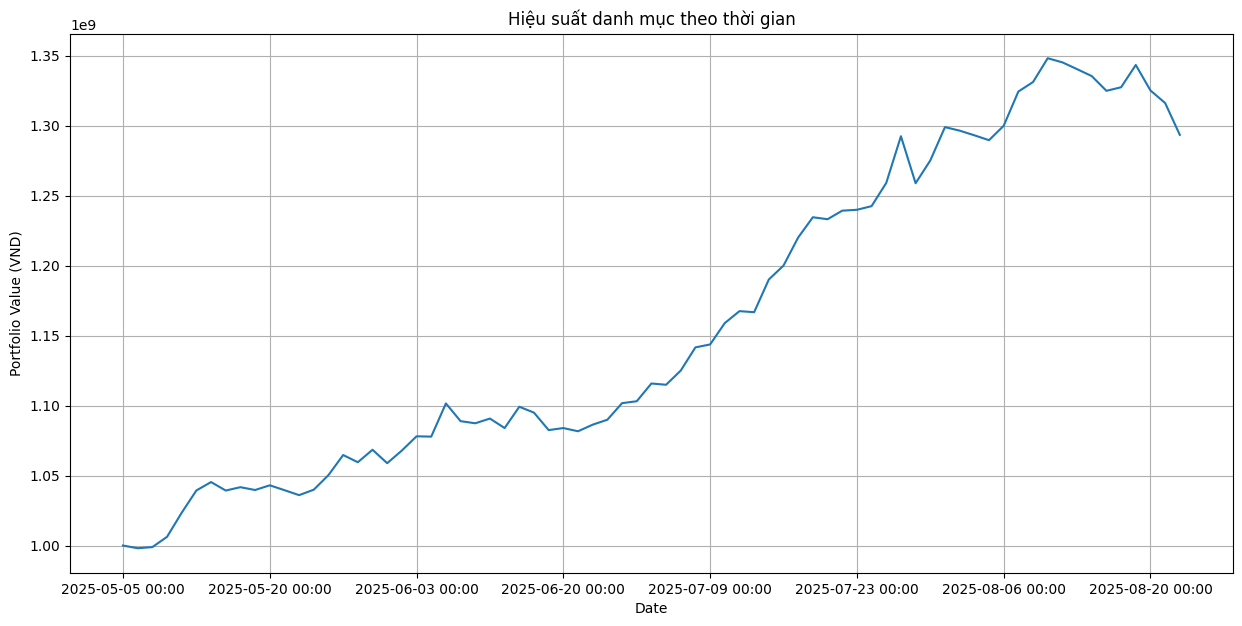

In [11]:
DATA_PATH_UPCOM = r"/kaggle/input/upcom-cleaned/UPCOM_cleaned.xlsx"
DATA_PATH_HOSE = r"/kaggle/input/vnx-cleaned/VNINDEX_cleaned.xlsx"
DATA_PATH_HNX = r"/kaggle/input/hnx-cleaned/HNXINDEX_cleaned.xlsx"
MODEL_PATH = r'/kaggle/input/lstm-weight/best_lstm_classifier_improved.pth'
SCALER_PATH = r"/kaggle/input/scaler-weight/feature_scaler.pkl"


data_upcom = pd.read_excel(DATA_PATH_UPCOM)
data_hose = pd.read_excel(DATA_PATH_HOSE)
data_hnx = pd.read_excel(DATA_PATH_HNX)
data_hose["exchange"] = "HOSE"
data_hnx["exchange"] = "HNX"
data_upcom["exchange"] = "UPCOM"
data_full = pd.concat([data_upcom, data_hose, data_hnx], ignore_index= True)



if data_full is not None:
    signal_model_params = {
        "top_features": ['price_vs_ema200', 'volatility_20', 'volume', 'macd_diff', 'bollinger_bw', 'ema_200', 'volatility_10', 'macd_signal', 'rsi', 'bollinger_pct', 'macd', 'ema_50', 'bollinger_lband', 'mfi_lag_3', 'bollinger_hband'],
        "time_steps": 10, "device": "cpu", "model_path": MODEL_PATH, "scaler_path": SCALER_PATH
    }


    result_df, trade_log_df = run_backtest(
        all_df=data_full,
        RiskClassifier=RiskClassifier,
        vnindex_df = data_hose,
        SignalClassifier=SignalClassifier,
        signal_model_params=signal_model_params,
        initial_balance=1_000_000_000 
    )

    if not result_df.empty:
        analyze_performance(
            portfolio_df=result_df,
            trade_log_df=trade_log_df,
            initial_balance=1_000_000_000 
        )
        
        print("\n--- BIỂU ĐỒ HIỆU SUẤT ---")
        result_df['value'].plot(figsize=(15, 7), title='Hiệu suất danh mục theo thời gian')
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value (VND)")
        plt.grid(True)
        plt.show()